# Monthly Milk Production

Data overview 

Monthly milk production - pounds per cow from January 1962 to December 1975

## Reading file 

In [1]:
import os
os.chdir(r"C:\Users\Soham\Desktop\milk")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
os.getcwd()

'C:\\Users\\Soham\\Desktop\\milk'

In [2]:
milk = pd.read_csv('milk_data_set.csv',index_col='Month')

Check out the head of data frame

In [3]:
milk.head()

,Monthly milk production (pounds per cow)
Month,
1962-01,589
1962-02,561
1962-03,640
1962-04,656
1962-05,727


 Make a index of time series

In [4]:
milk.index = pd.to_datetime(milk.index)
print(milk.index)

DatetimeIndex(['1962-01-01', '1962-02-01', '1962-03-01', '1962-04-01',
               '1962-05-01', '1962-06-01', '1962-07-01', '1962-08-01',
               '1962-09-01', '1962-10-01',
               ...
               '1975-03-01', '1975-04-01', '1975-05-01', '1975-06-01',
               '1975-07-01', '1975-08-01', '1975-09-01', '1975-10-01',
               '1975-11-01', '1975-12-01'],
              dtype='datetime64[ns]', name='Month', length=168, freq=None)


## Plot out the time series data

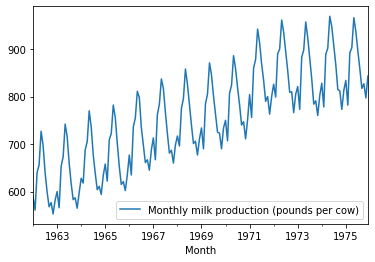

In [5]:
milk.plot()

## Train-Test split

Create a train test split using indexing (hint - .head() , .tail() , .iloc[])

Here , basically we want to specify that the test set is the last 12 months of data , with everything before it is the training 

In [6]:
milk.info()
train_set = milk.head(156)
test_set = milk.tail(12)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 168 entries, 1962-01-01 to 1975-12-01
Data columns (total 1 columns):
Monthly milk production (pounds per cow)    168 non-null int64
dtypes: int64(1)
memory usage: 2.6 KB


## Scale the data

Use sklearn.preprocessing to scale data using MinMaxScaler. Remember to only fit_transform on the training data , then transform the test data

In [7]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_set)
test_scaled = scaler.fit_transform(test_set)

## Batch function

We will need a function that can feed batches of the training data

In [8]:
def next_batch(training_data,batch_size,steps):
    
    # Grab a random starting point for each batch
    rand_start = np.random.randint(0,len(training_data)-steps)
    
    # Create Y data for time series in the batches
    y_batch = np.array(training_data[rand_start:rand_start+steps+1]).reshape(1,steps+1)
    return y_batch[:,:-1].reshape(-1,steps,1),y_batch[:,1:].reshape(-1,steps,1)

## Setting up RNN model

In [9]:
import tensorflow as tf

## The constants

Define a constant in a single cell . Here , in parenthesis of each constant , there are some values which are for solution . you can change it.

num_inputs(1) (Just one feature, the time series)

num_time_steps (12) (Number of steps in each batch)

num_neurons (100) (100 neuron layer) 

num_outputs (1) (Just one output, predicted time series)

learning_rate (0.03) (How quickly model is adopted the problem , range between 0.0 and 1.0)

num_train_iterations (4000) (How many iterations to go through training steps)

batch_size (1) (Size of the batch of data)

In [10]:
num_inputs = 1
num_time_steps = 12
num_neurons = 100
num_outputs = 1
learning_rate = 0.03
num_train_iterations = 4000
batch_size = 1

## Create placeholders for X and y

The shape for these placeholders X and y should be [None,num_time_steps-1,num_inputs] and [None,num_time_steps-1,num_outputs] respectively . The reason we use num_time_steps-1 is because each of this will be one step shorter than original time series size , because we are training the RNN network to predict one point into the future based on the input sequence

In [11]:
X = tf.placeholder(tf.float32,[None,num_time_steps,num_inputs])
y = tf.placeholder(tf.float32,[None,num_time_steps,num_outputs])

## Create RNN layer

In [12]:
cell = tf.contrib.rnn.OutputProjectionWrapper(tf.contrib.rnn.BasicLSTMCell(
    num_units=num_neurons, activation =tf.nn.relu),output_size = num_outputs)

W0716 17:28:08.745447  3452 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W0716 17:28:08.749447  3452 deprecation.py:323] From <ipython-input-12-a24cf5a927c9>:2: BasicLSTMCell.__init__ (from tensorflow.python.ops.rnn_cell_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.


Now pass in the cells varriable into  tf.nn.dynamic_rnn along with first placeholder X

In [13]:
outputs , states = tf.nn.dynamic_rnn(cell,X,dtype = tf.float32)

W0716 17:28:08.758448  3452 deprecation.py:323] From <ipython-input-13-2a82ee6a6a5d>:1: dynamic_rnn (from tensorflow.python.ops.rnn) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
W0716 17:28:09.106467  3452 deprecation.py:506] From C:\Users\Soham\Anaconda3\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0716 17:28:09.126469  3452 deprecation.py:506] From C:\Users\Soham\Anaconda3\lib\site-packages\tensorflow\python\ops\rnn_cell_impl.py:738: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with 

## Loss function and optimizer

Create mean squared error loss function, use it to minimize an Adam
Optimizer, remember to pass in learning rate

In [14]:
loss = tf.reduce_mean(tf.square(outputs-y))
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
train = optimizer.minimize(loss)

Intialize the global variables and create an instance of tf.train.Saver()

In [15]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

## Session

Run Tensor flow session that trains on the batches created by next_batch
function and also add a loss evalution for every 100 training iterations

In [16]:
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.9)

In [17]:
with tf.Session(config = tf.ConfigProto(gpu_options = gpu_options)) as sess:

    sess.run(init)

    for iteration in range(num_train_iterations):
        
        X_batch , y_batch = next_batch(train_scaled,batch_size,num_time_steps)
        
        sess.run(train,feed_dict={X:X_batch,y:y_batch})
        if iteration %100 == 0:
            mse = loss.eval(feed_dict={X:X_batch,y:y_batch})
            print (iteration,"\tMSE",mse)
    saver.save(sess, "./ex_time_series_model_codealong")

0 	MSE 0.23558016
100 	MSE 0.009815755
200 	MSE 0.010543906
300 	MSE 0.0098060975
400 	MSE 0.01111576
500 	MSE 0.00840737
600 	MSE 0.007702127
700 	MSE 0.0070442776
800 	MSE 0.00526855
900 	MSE 0.007758729
1000 	MSE 0.008473936
1100 	MSE 0.00747049
1200 	MSE 0.0039997157
1300 	MSE 0.0035143867
1400 	MSE 0.00960674
1500 	MSE 0.008685014
1600 	MSE 0.006482022
1700 	MSE 0.0055405307
1800 	MSE 0.0035317289
1900 	MSE 0.001851603
2000 	MSE 0.001996971
2100 	MSE 0.0034168127
2200 	MSE 0.0077892574
2300 	MSE 0.0022138495
2400 	MSE 0.012802399
2500 	MSE 0.0049281134
2600 	MSE 0.0026468337
2700 	MSE 0.0025758995
2800 	MSE 0.0040336493
2900 	MSE 0.0031563258
3000 	MSE 0.0089273425
3100 	MSE 0.0020081068
3200 	MSE 0.004306611
3300 	MSE 0.0038230494
3400 	MSE 0.0040768776
3500 	MSE 0.006112261
3600 	MSE 0.0037234237
3700 	MSE 0.0039736107
3800 	MSE 0.006903097
3900 	MSE 0.0015628352


## Testing data

In [18]:
test_set

,Monthly milk production (pounds per cow)
Month,
1975-01-01,834
1975-02-01,782
1975-03-01,892
1975-04-01,903
1975-05-01,966
1975-06-01,937
1975-07-01,896
1975-08-01,858
1975-09-01,817


## Generative session

Fill out the session code to generate 12 months of data based of the last 12 months of data from the training set

In [19]:
with tf.Session() as sess:
    saver.restore(sess, "./ex_time_series_model_codealong")
    train_seed = list(train_scaled[-12:])
    for iteration in range (12):
        X_batch = np.array(train_seed[-num_time_steps:]).reshape(1,num_time_steps,1)
        y_pred = sess.run(outputs,feed_dict = {X:X_batch})
        train_seed.append(y_pred[0,-1,0])

W0716 17:29:15.407260  3452 deprecation.py:323] From C:\Users\Soham\Anaconda3\lib\site-packages\tensorflow\python\training\saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


In [20]:
train_seed

[array([0.66105769]),
 array([0.54086538]),
 array([0.80769231]),
 array([0.83894231]),
 array([1.]),
 array([0.94711538]),
 array([0.85336538]),
 array([0.75480769]),
 array([0.62980769]),
 array([0.62259615]),
 array([0.52884615]),
 array([0.625]),
 0.67060155,
 0.57558554,
 0.79733145,
 0.80050856,
 0.9485555,
 0.8570923,
 0.7833641,
 0.6964095,
 0.5896877,
 0.6297616,
 0.54758525,
 0.6143918]

Grab the portion of the results that are generated values and apply inverse_transform on them to turn them back into milk production value units lbs per cow and reshape results to be (12,1)

In [21]:
results = scaler.inverse_transform(np.array(train_seed[12:]).reshape(12,1))

Create a new coloumn on test_set called "Generated" and set it equal to the generated results

In [22]:
test_set['Generated'] = results

C:\Users\Soham\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [23]:
test_set

,Monthly milk production (pounds per cow),Generated
Month,,
1975-01-01,834,905.390625
1975-02-01,782,887.907715
1975-03-01,892,928.708984
1975-04-01,903,929.293579
1975-05-01,966,956.534180
1975-06-01,937,939.705017
1975-07-01,896,926.139038
1975-08-01,858,910.139404
1975-09-01,817,890.502563


## Plot out training-testing result for comparison

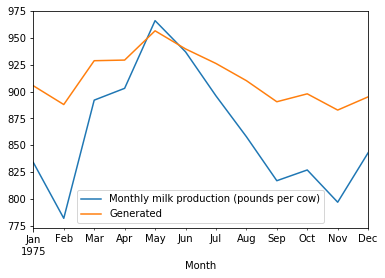

In [24]:
test_set.plot()